<a href="https://colab.research.google.com/github/VinhDevNguyen/Machine-Learning/blob/master/Project/Audio_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset from kaggle

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [5]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
! mkdir ~/.kaggle

In [0]:
! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge               COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-06-10 00:09:23          71785  
roche-data-science-coalition/uncover                            UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53          10483  
kwullum/fatal-police-shootings-in-the-us                        Fatal Police Shootings in the US                      1MB  2017-09-22 19:18:21          12617  
Cornell-University/arxiv                                        ArXiv Metadata                                        2GB  2020-05-06 23:18:35              2  
sudalairajkumar/daily-temperature-of-maj

In [9]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:13<00:00, 112MB/s] 
100% 1.21G/1.21G [00:13<00:00, 93.0MB/s]


In [0]:
! mkdir gtzan-dataset-music-genre-classification

In [12]:
! unzip gtzan-dataset-music-genre-classification.zip -d gtzan-dataset-music-genre-classification

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: gtzan-dataset-music-genre-classification/Data/features_30_sec.csv  
  inflating: gtzan-dataset-music-genre-classification/Data/features_3_sec.csv  
  inflating: gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav  
  inflating: gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00001.wav  
  inflating: gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00002.wav  
  inflating: gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00003.wav  
  inflating: gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00004.wav  
  inflating: gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00005.wav  
  inflating: gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00006.wav  
  inflating: gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.0000

# Preprocessing audio data for Deep Learning

## Import module

In [0]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

### Waveform

In [0]:
file = "/content/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav"

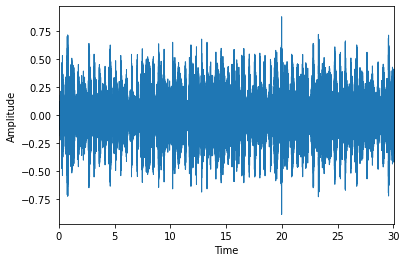

In [21]:
signal, sr = librosa.load(file,) # sr * T -> 22050 *30
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### fft -> spectrum

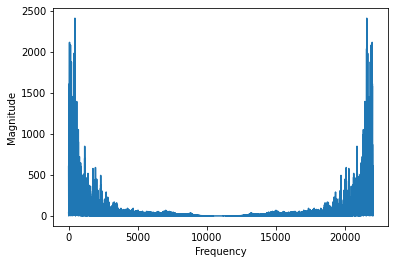

In [28]:
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

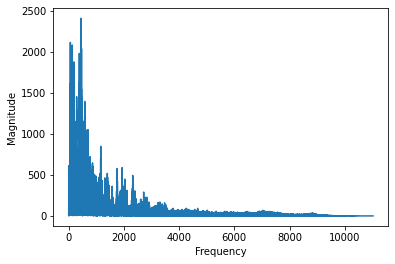

In [32]:
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

### stft -> Spectrogram